In [1]:
import os
import pandas as pd
import numpy as np
import regex as re
import mytrain_lib_cluster as ml
import json
import matplotlib.pyplot as plt
import seaborn as sn
import importlib as il
%matplotlib inline

In [2]:
path_results = 'F://TFG//results//'
path_scores  = path_results + 'scores//'
path_graphs = 'F://TFG//graphs//'
path_summary = path_graphs + 'summary//'
path_outputs = path_results + 'outputs//'

## Proof of Concept

Queremos sacar:
- Configuraciones con mejores accuracy en el test
- Configuraciones con menor y mayor bias (underfitting) y variance (overfitting)
- Hiperparámetros con mayor varianza en el error y accuracy &rarr; más críticos
- Hiperparámetros con menor varianza en el error y accuracy &rarr; menos críticos
- Configuraciones con más y menos precisión y recall
- Analizar AUC-ROC

In [242]:
with open(path_scores+'config.json','r') as config:
    res = json.load(config)

In [243]:
res[0].get('acc_test',-1)

0.4407894736842105

In [244]:
accuracy = []
for c in res:
    accuracy.append(c.get('acc_test',-1))
accuracy = np.array(accuracy)

In [245]:
accuracy[794]

0.51171875

In [246]:
res[0].keys()

dict_keys(['temp', 'path', 'confnum', 'model', 'config_model', 'optimizer', 'config_optimizer', 'criterion', 'scaler', 'batch_size', 'epochs', 'cv_results', 'error_train', 'acc_train', 'error_test', 'acc_test', 'cm'])

In [247]:
print(res[0]['config_model'].keys())
print(res[0]['config_optimizer'].keys())
print(res[1]['config_optimizer'].keys())

dict_keys(['hidden_neurons', 'p'])
dict_keys(['momentum', 'weight_decay', 'nesterov', 'dampening', 'lr'])
dict_keys(['weight_decay', 'betas', 'lr'])


#### Configurations with highest test accuracy

In [248]:
def get_accuracy(config):
    return config.get('acc_test',None)

def get_error(config):
    error = config.get('error_train',None)
    if error>1000: error = np.nan
    return error

def get_bias(config):
    return get_error(config)

def get_variance(config):
    return config.get('error_test',get_bias(config)*2) - get_bias(config) 

def get_diff_biasvariance(config):
    return get_variance(config) - get_bias(config)

def get_sorted_configs(jsons,operation,order='max',n=5,return_index=True):
    jsons = np.array(jsons)
    acc_list = list(map(operation,jsons))
    indexes = np.array(acc_list).argsort()
    if order=='max': indexes = indexes[-n:][::-1]
    elif order=='min': pass
    else: raise Exception('Value have to be "min" or "max"') 
    indexes = indexes[:n] 

    if return_index: 
        return indexes
    else: 
        return jsons[indexes]

def architecture_string(nn):
    _r_ = ''
    for n in nn:
        _r_ += str(n) + '_'
    return _r_[:-1]

def df_config(jsons):
    return -1

In [249]:
get_sorted_configs(res, get_accuracy, order='max', n=5, return_index=1)

array([794, 714, 245, 717, 428], dtype=int64)

In [250]:
get_sorted_configs(res, get_error, order='min', n=5, return_index=1)

array([950, 448, 967, 670, 768], dtype=int64)

In [251]:
get_sorted_configs(res, get_variance, order='min')

array([516, 880, 549, 767, 163], dtype=int64)

In [252]:
res[0].keys()

dict_keys(['temp', 'path', 'confnum', 'model', 'config_model', 'optimizer', 'config_optimizer', 'criterion', 'scaler', 'batch_size', 'epochs', 'cv_results', 'error_train', 'acc_train', 'error_test', 'acc_test', 'cm'])

In [253]:
res[0]['model']

"<class 'goalnets.NeuralNetworkDOClass'>"

In [254]:
def get_class(strclass):
    if '.' not in strclass:
        return strclass
    return strclass.split("'")[1].split('.')[-1]

get_class("<class 'torch.nn.modules.loss.CrossEntropyLoss'>")

def get_betas(betas):
    if betas is not None:
        return betas[0], betas[1]
    else: return np.NAN, np.NAN

In [255]:
df = pd.DataFrame({})

for r in res:
    serie = pd.Series(dtype=object)
    serie['confnum'] = r.get('confnum',None)[0]
    serie['model'] = get_class(r.get('model',None))
    serie['architecture'] = architecture_string(r['config_model'].get('hidden_neurons',None))
    serie['p'] = r['config_model'].get('p',0)
    serie['optimizer'] = get_class(r['optimizer'])
    # optim params
    serie['momentum'] = r['config_optimizer'].get('momentum',None)
    serie['weight_decay'] = r['config_optimizer'].get('weight_decay',None)
    serie['nesterov'] = r['config_optimizer'].get('nesterov',None)
    serie['dampening'] = r['config_optimizer'].get('dampening',None)
    serie['lr'] = r['config_optimizer'].get('lr',None)
    serie['weight_decay'] = r['config_optimizer'].get('weight_decay',None)
    serie['b1'], serie['b2'] = get_betas(r['config_optimizer'].get('betas',None))
    serie['lr'] = r['config_optimizer'].get('lr',None)   
    serie['criterion'] = get_class(r['criterion'])
    serie['scaler'] = get_class(r['scaler'])
    serie['batch_size'] = r['batch_size']
    serie['epochs'] = r['epochs']
    # metrics
    serie['error_train'] = get_error(r)
    serie['error_test'] = r.get('error_test',np.NAN)
    serie['acc_train'] = r.get('acc_train',np.NAN)
    serie['acc_test'] = get_accuracy(r)
    # compute recall, recall, AUC...

    df = pd.concat([df,serie],axis=1,ignore_index=True)

df = df.T.set_index('confnum').fillna(value=np.nan)

In [256]:
df

,model,architecture,p,optimizer,momentum,weight_decay,nesterov,dampening,lr,b1,b2,criterion,scaler,batch_size,epochs,error_train,error_test,acc_train,acc_test
confnum,,,,,,,,,,,,,,,,,,,
0,NeuralNetworkDOClass,120_50_25,0.120553,SGD,0.891773,0.000000,0.0,0.000000,0.00100,NaN,NaN,CrossEntropyLoss,basic,16,250,0.817060,1.516803,0.635110,0.440789
1,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.10000,0.832620,0.799159,CrossEntropyLoss,MinMaxScaler,32,250,1.072742,1.089138,0.455882,0.451389
2,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.832620,0.990000,CrossEntropyLoss,basic,64,250,0.905230,1.245437,0.576287,0.464844
3,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.778157,0.990000,CrossEntropyLoss,Normalizer,16,250,0.883490,1.247529,0.584559,0.467105
4,NeuralNetworkBNClass,120_50_25,0.000000,Adam,NaN,0.000000,NaN,NaN,0.00001,0.001000,0.010000,CrossEntropyLoss,basic,128,250,0.924791,1.127353,0.573242,0.453125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NeuralNetworkDOClass,120_50_25,0.108977,Adam,NaN,0.000000,NaN,NaN,0.00010,0.001000,0.978618,CrossEntropyLoss,MaxAbsScaler,128,250,0.962390,1.161603,0.539062,0.488281
996,NeuralNetworkDOClass,120_50_25,0.109763,SGD,0.963663,0.000000,0.0,0.043565,0.00010,NaN,NaN,CrossEntropyLoss,MaxAbsScaler,16,250,1.000533,1.149259,0.516544,0.483553
997,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.211827,NaN,NaN,0.00100,0.778157,0.870012,CrossEntropyLoss,StandardScaler,64,250,1.069350,1.070615,0.455882,0.449219


In [257]:
error_grouping = df.groupby(['weight_decay']).agg(
    {'scaler': ['count'], 'error_train': ['mean','min', 'var'], 'acc_test':['mean','max', 'var']}
)
error_grouping

scaler error_train                       acc_test            \
              count        mean       min        var      mean       max   
weight_decay                                                               
0.000000        613    0.807769  0.000000   0.135602  0.447623  0.511719   
0.211827        143    1.189541  0.531121   2.871058  0.449543  0.496528   
0.218794        122    1.056305  0.742417   0.003401  0.450520  0.493056   
0.322947        122    1.743710  0.237242  48.454698  0.449708  0.480469   

                        
                   var  
weight_decay            
0.000000      0.001765  
0.211827      0.000449  
0.218794      0.000268  
0.322947      0.000194

In [2]:
'anova' in 'ANOVA'.lower()

True

In [258]:
(pd.DataFrame(error_grouping.var(),columns=['weight_decay']).T
                            .drop(['scaler',('error_train','var'),('acc_test','var')],axis=1))

error_train            acc_test          
                    mean       min      mean       max
weight_decay    0.156741  0.106314  0.000002  0.000165

In [259]:
def fun_grouped_error(c):
    return df.groupby(c).agg(
                                {'scaler': ['count'],
                                 'error_train': ['mean','min', 'var'],
                                 'acc_test':['mean','max', 'var']
                                }
                            )

In [260]:
cols = ['model', 'p', 'optimizer', 'momentum', 'weight_decay',
       'nesterov', 'dampening', 'lr', 'b1', 'b2', 'scaler',
       'batch_size']

errorvar_hyperparams = pd.DataFrame()
for c in cols:
    grouped_error = fun_grouped_error(c)
    # if isinstance(c,list): c = 'betas'
    resume_error = (pd.DataFrame(grouped_error.var(),columns=[c]).T
                            .drop(['scaler',('error_train','var'),('acc_test','var')],axis=1))
    errorvar_hyperparams = pd.concat([errorvar_hyperparams,resume_error])

In [261]:
errorvar_hyperparams = errorvar_hyperparams.sort_values(('acc_test','max'),ascending=False)
errorvar_hyperparams

error_train                    acc_test          
                    mean           min          mean       max
weight_decay    0.156741  1.063141e-01  1.505547e-06  0.000165
nesterov        0.001268  1.506290e-11  3.307718e-07  0.000069
model           0.075156  4.738715e-02  1.155655e-04  0.000063
b1              0.243590  3.492101e-15  9.145344e-05  0.000036
dampening       0.002128  1.116644e-09  1.167180e-06  0.000022
p               0.081974  3.862207e-02  4.683888e-05  0.000020
momentum        0.000451  4.371353e-07  1.883925e-06  0.000019
lr              0.044317  1.102332e-01  3.971861e-05  0.000012
b2              0.727584  1.719064e-05  2.672485e-04  0.000011
scaler          0.046393  3.656168e-11  1.691863e-05  0.000009
optimizer       0.021617  6.219318e-10  7.778940e-05  0.000008
batch_size      0.019053  2.984961e-11  1.713354e-06  0.000005

In [262]:
fun_grouped_error('lr')

scaler error_train                           acc_test            \
         count        mean           min        var      mean       max   
lr                                                                        
0.00001    198    1.044507  7.424171e-01   0.002471  0.455325  0.507812   
0.00010    199    0.939830  1.092696e-05   0.070871  0.454701  0.503906   
0.00100    205    0.867606  1.321382e-07   0.119819  0.447606  0.509868   
0.01000    181    0.809070  0.000000e+00   0.148641  0.443878  0.503906   
0.10000    217    1.343053  3.526845e-05  29.937265  0.441310  0.511719   

                   
              var  
lr                 
0.00001  0.000193  
0.00010  0.000758  
0.00100  0.001310  
0.01000  0.002161  
0.10000  0.001504

<BarContainer object of 12 artists>

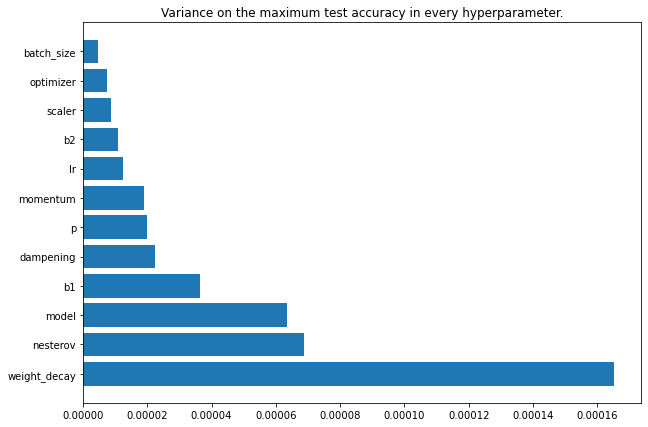

In [263]:
plt.figure(figsize=(10,7))
plt.title('Variance on the maximum test accuracy in every hyperparameter.')
plt.barh(y=errorvar_hyperparams.index,width=errorvar_hyperparams[('acc_test','max')])
# plt.savefig(path_summary + 'randomsearch_varmaxtestacc' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

<BarContainer object of 12 artists>

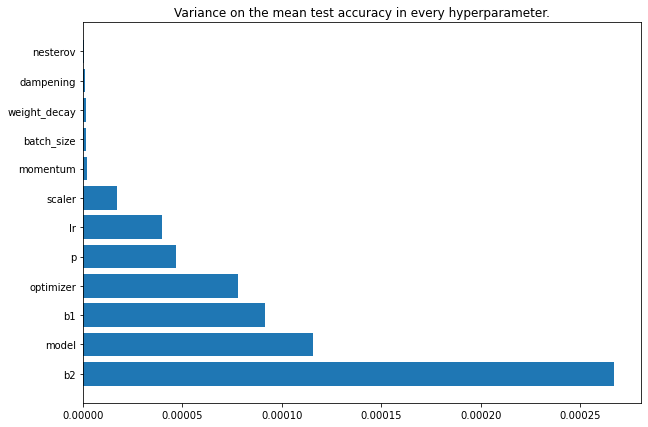

In [264]:
plt.figure(figsize=(10,7))
plt.title('Variance on the mean test accuracy in every hyperparameter.')
data_plot = errorvar_hyperparams.sort_values(('acc_test','mean'),ascending=False)
plt.barh(y=data_plot.index,width=data_plot[('acc_test','mean')])
# plt.savefig(path_summary + 'randomsearch_varmeantestacc' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

In [265]:
fun_grouped_error('lr')

scaler error_train                           acc_test            \
         count        mean           min        var      mean       max   
lr                                                                        
0.00001    198    1.044507  7.424171e-01   0.002471  0.455325  0.507812   
0.00010    199    0.939830  1.092696e-05   0.070871  0.454701  0.503906   
0.00100    205    0.867606  1.321382e-07   0.119819  0.447606  0.509868   
0.01000    181    0.809070  0.000000e+00   0.148641  0.443878  0.503906   
0.10000    217    1.343053  3.526845e-05  29.937265  0.441310  0.511719   

                   
              var  
lr                 
0.00001  0.000193  
0.00010  0.000758  
0.00100  0.001310  
0.01000  0.002161  
0.10000  0.001504

Text(0, 0.5, 'test accuracy')

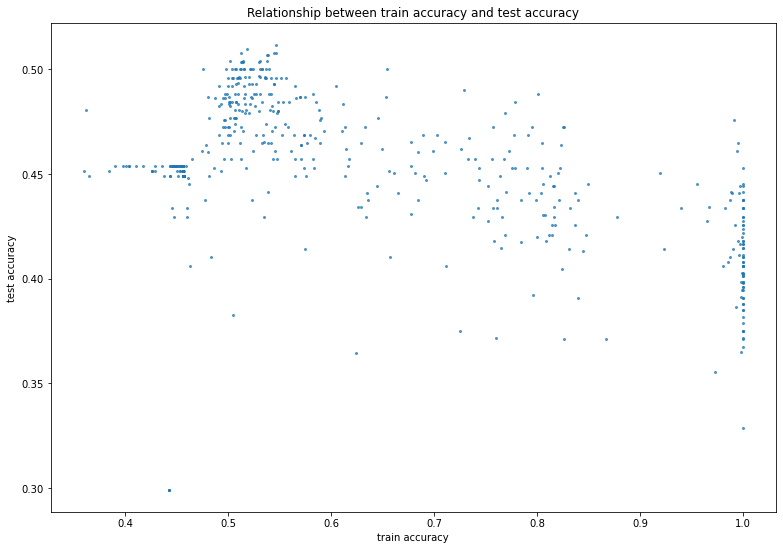

In [266]:
#   SCATTER PLOT - train_error vs test_acc
data_plot = df[df.error_train<3]
plt.figure(figsize=(13,9))
plt.title('Relationship between train accuracy and test accuracy')
plt.scatter(x=data_plot.acc_train,y=data_plot.acc_test, alpha=.7, s=4)
plt.xlabel('train accuracy'); plt.ylabel('test accuracy')
# plt.savefig(path_summary + 'scatter_trainacc_testacc' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

Son las configuraciones que estan por el medio las que más me interesan y que pueden tener potencial para mejorar el accuracy en el test.

(0.0, 20.0)

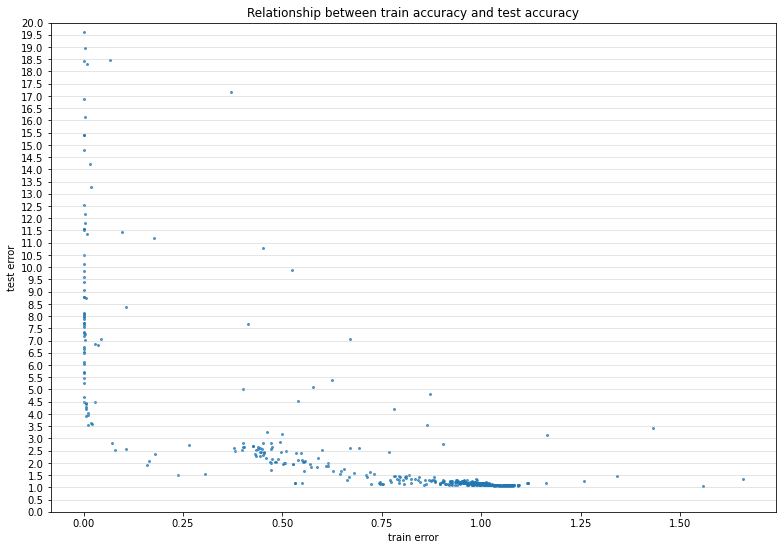

In [267]:
#   SCATTER PLOT - train_error vs test_acc
data_plot = df[df.error_train<3]
plt.figure(figsize=(13,9))
plt.title('Relationship between train accuracy and test accuracy')
plt.scatter(x=data_plot.error_train,y=data_plot.error_test, alpha=.7, s=4)
plt.xlabel('train error'); plt.ylabel('test error')
plt.yticks(np.linspace(start=0,stop=22,num=45))
plt.grid(axis='y',alpha=.4)
plt.ylim(0,20)
# plt.savefig(path_summary + 'scatter_trainerror_testerror' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

Vemos aqui como se distribuye el error (train y test) en las diferentes configuraciones.

Text(0, 0.5, 'test accuracy')

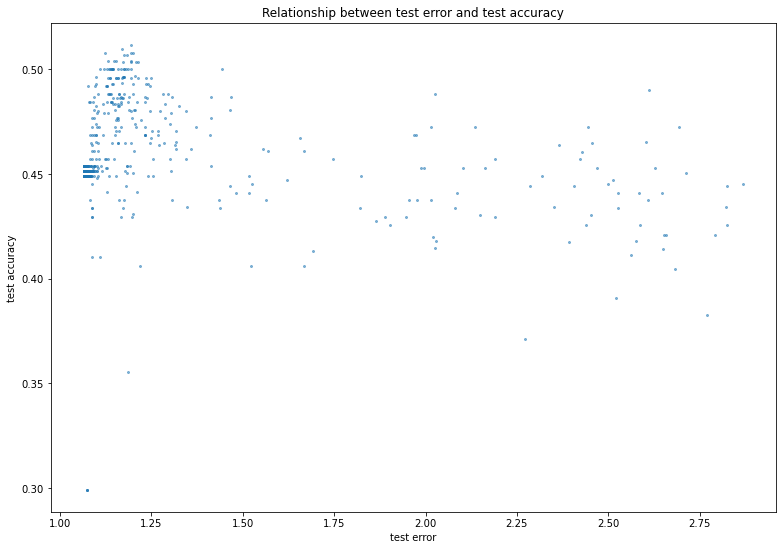

In [268]:
#   SCATTER PLOT - test_error vs test_acc
data_plot = df[df.error_test<3]
plt.figure(figsize=(13,9))
plt.title('Relationship between test error and test accuracy')
plt.scatter(x=data_plot.error_test,y=data_plot.acc_test, alpha=.5, s=4)
plt.xlabel('test error'); plt.ylabel('test accuracy')
# plt.savefig(path_summary + 'scatter_testerror_testacc' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

No existe una muy fuerte correlacion entre el error y el accuracy en el test. Lo que podria sugerir, que o bien la funcion de loss no es la optima o que el error no es la mejor metrica para medir el modelo.

Text(0, 0.5, 'train accuracy')

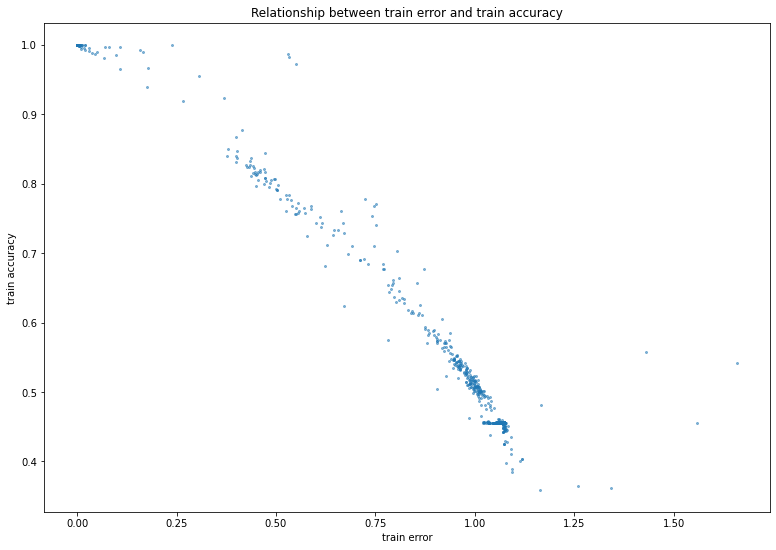

In [269]:
#   SCATTER PLOT - test_error vs test_acc
data_plot = df[df.error_train<3]
plt.figure(figsize=(13,9))
plt.title('Relationship between train error and train accuracy')
plt.scatter(x=data_plot.error_train,y=data_plot.acc_train, alpha=.5, s=4)
plt.xlabel('train error'); plt.ylabel('train accuracy')
# plt.savefig(path_summary + 'scatter_trainerror_trainacc' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

In [270]:
# 1-. ACABAR AUC-ROC
# 2-. Acabar de analizar los hiperparámetros óptimos
# 3-. Comprovar ejecuciones para Anova, featsel, PCA, variance threshold y nueva ejecucion lanzada...
# 4-. Lanzar experimentos de optimizacion de la arquitectura con muy poca optimizacion de hiperparámetros

### Other metrics

#### Precision Score

In [271]:
res[0]['cm']

[[15.0, 47.0, 13.0], [29.0, 86.0, 23.0], [17.0, 41.0, 33.0]]

In [272]:
np.sum([[1,2,3],[2,5,8]],axis=0)


array([ 3,  7, 11])

In [273]:
def precision_score(conf_matrix):
    conf_matrix = np.array(conf_matrix)
    tpfn = np.sum(conf_matrix,axis=1)
    tp = conf_matrix.diagonal()
    return tp/tpfn

def add_precision(df,jsons):
    if 'precision_draw' in df.columns: return df
    p0,p1,p2 = np.array([ precision_score(j['cm']) for j in jsons ]).T
    precisions = pd.DataFrame({
                                'precision_draw': p0,
                                'precision_home': p1,
                                'precision_away': p2
                             })
    return pd.concat([df,precisions],axis=1)

In [274]:
precision_score(res[0]['cm'])

array([0.2       , 0.62318841, 0.36263736])

In [275]:
df = add_precision(df,res)
df

,model,architecture,p,optimizer,momentum,weight_decay,nesterov,dampening,lr,b1,...,scaler,batch_size,epochs,error_train,error_test,acc_train,acc_test,precision_draw,precision_home,precision_away
0,NeuralNetworkDOClass,120_50_25,0.120553,SGD,0.891773,0.000000,0.0,0.000000,0.00100,NaN,...,basic,16,250,0.817060,1.516803,0.635110,0.440789,0.200000,0.623188,0.362637
1,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.10000,0.832620,...,MinMaxScaler,32,250,1.072742,1.089138,0.455882,0.451389,0.000000,1.000000,0.000000
2,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.832620,...,basic,64,250,0.905230,1.245437,0.576287,0.464844,0.112903,0.686957,0.417722
3,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.778157,...,Normalizer,16,250,0.883490,1.247529,0.584559,0.467105,0.173333,0.666667,0.406593
4,NeuralNetworkBNClass,120_50_25,0.000000,Adam,NaN,0.000000,NaN,NaN,0.00001,0.001000,...,basic,128,250,0.924791,1.127353,0.573242,0.453125,0.032258,0.765217,0.329114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NeuralNetworkDOClass,120_50_25,0.108977,Adam,NaN,0.000000,NaN,NaN,0.00010,0.001000,...,MaxAbsScaler,128,250,0.962390,1.161603,0.539062,0.488281,0.064516,0.756522,0.430380
996,NeuralNetworkDOClass,120_50_25,0.109763,SGD,0.963663,0.000000,0.0,0.043565,0.00010,NaN,...,MaxAbsScaler,16,250,1.000533,1.149259,0.516544,0.483553,0.000000,0.746377,0.483516
997,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.211827,NaN,NaN,0.00100,0.778157,...,StandardScaler,64,250,1.069350,1.070615,0.455882,0.449219,0.000000,1.000000,0.000000
998,NeuralNetworkDOClass,120_50_25,0.143038,SGD,0.891773,0.000000,0.0,0.462798,0.00010,NaN,...,MinMaxScaler,128,250,1.066114,1.067451,0.457031,0.449219,0.000000,1.000000,0.000000


#### Recall Score

In [276]:
def recall_score(conf_matrix):
    conf_matrix = np.array(conf_matrix)
    tpfn = np.sum(conf_matrix,axis=0)
    tp = conf_matrix.diagonal()
    recall = tp/tpfn
    recall = np.nan_to_num(recall)
    return recall

def add_recall(df,jsons):
    if 'recall_draw' in df.columns: return df
    p0,p1,p2 = np.array([ recall_score(j['cm']) for j in jsons ]).T
    recalls = pd.DataFrame({
                                'recall_draw': p0,
                                'recall_home': p1,
                                'recall_away': p2
                             })
    return pd.concat([df,recalls],axis=1)

In [277]:
print(res[1]['cm'])
recall_score(res[1]['cm'])

[[0.0, 70.0, 0.0], [0.0, 130.0, 0.0], [0.0, 88.0, 0.0]]


<ipython-input-276-11704a69149a>:5: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/tpfn


array([0.        , 0.45138889, 0.        ])

In [278]:
df = add_recall(df,res)
df

<ipython-input-276-11704a69149a>:5: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/tpfn


,model,architecture,p,optimizer,momentum,weight_decay,nesterov,dampening,lr,b1,...,error_train,error_test,acc_train,acc_test,precision_draw,precision_home,precision_away,recall_draw,recall_home,recall_away
0,NeuralNetworkDOClass,120_50_25,0.120553,SGD,0.891773,0.000000,0.0,0.000000,0.00100,NaN,...,0.817060,1.516803,0.635110,0.440789,0.200000,0.623188,0.362637,0.245902,0.494253,0.478261
1,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.10000,0.832620,...,1.072742,1.089138,0.455882,0.451389,0.000000,1.000000,0.000000,0.000000,0.451389,0.000000
2,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.832620,...,0.905230,1.245437,0.576287,0.464844,0.112903,0.686957,0.417722,0.241379,0.506410,0.464789
3,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.778157,...,0.883490,1.247529,0.584559,0.467105,0.173333,0.666667,0.406593,0.260000,0.505495,0.513889
4,NeuralNetworkBNClass,120_50_25,0.000000,Adam,NaN,0.000000,NaN,NaN,0.00001,0.001000,...,0.924791,1.127353,0.573242,0.453125,0.032258,0.765217,0.329114,0.117647,0.497175,0.419355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NeuralNetworkDOClass,120_50_25,0.108977,Adam,NaN,0.000000,NaN,NaN,0.00010,0.001000,...,0.962390,1.161603,0.539062,0.488281,0.064516,0.756522,0.430380,0.210526,0.533742,0.459459
996,NeuralNetworkDOClass,120_50_25,0.109763,SGD,0.963663,0.000000,0.0,0.043565,0.00010,NaN,...,1.000533,1.149259,0.516544,0.483553,0.000000,0.746377,0.483516,0.000000,0.502439,0.444444
997,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.211827,NaN,NaN,0.00100,0.778157,...,1.069350,1.070615,0.455882,0.449219,0.000000,1.000000,0.000000,0.000000,0.449219,0.000000
998,NeuralNetworkDOClass,120_50_25,0.143038,SGD,0.891773,0.000000,0.0,0.462798,0.00010,NaN,...,1.066114,1.067451,0.457031,0.449219,0.000000,1.000000,0.000000,0.000000,0.449219,0.000000


#### F-1 Score

In [279]:
def f1_score(conf_matrix):
    conf_matrix = np.array(conf_matrix)
    precision = (precision_score(conf_matrix))
    recall = recall_score(conf_matrix)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

def add_f1score(df,jsons):
    if 'f1_draw' in df.columns: return df
    p0,p1,p2 = np.array([ f1_score(j['cm']) for j in jsons ]).T
    f1_scores = pd.DataFrame({
                                'f1_draw': p0,
                                'f1_home': p1,
                                'f1_away': p2
                             })
    return pd.concat([df,f1_scores.fillna(0)],axis=1)

In [280]:
f1_score(res[0]['cm'])

array([0.22058824, 0.55128205, 0.4125    ])

In [281]:
df = add_f1score(df,res)
df

<ipython-input-276-11704a69149a>:5: RuntimeWarning: invalid value encountered in true_divide
  recall = tp/tpfn


,model,architecture,p,optimizer,momentum,weight_decay,nesterov,dampening,lr,b1,...,acc_test,precision_draw,precision_home,precision_away,recall_draw,recall_home,recall_away,f1_draw,f1_home,f1_away
0,NeuralNetworkDOClass,120_50_25,0.120553,SGD,0.891773,0.000000,0.0,0.000000,0.00100,NaN,...,0.440789,0.200000,0.623188,0.362637,0.245902,0.494253,0.478261,0.220588,0.551282,0.412500
1,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.10000,0.832620,...,0.451389,0.000000,1.000000,0.000000,0.000000,0.451389,0.000000,0.000000,0.622010,0.000000
2,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.832620,...,0.464844,0.112903,0.686957,0.417722,0.241379,0.506410,0.464789,0.153846,0.583026,0.440000
3,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.778157,...,0.467105,0.173333,0.666667,0.406593,0.260000,0.505495,0.513889,0.208000,0.575000,0.453988
4,NeuralNetworkBNClass,120_50_25,0.000000,Adam,NaN,0.000000,NaN,NaN,0.00001,0.001000,...,0.453125,0.032258,0.765217,0.329114,0.117647,0.497175,0.419355,0.050633,0.602740,0.368794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NeuralNetworkDOClass,120_50_25,0.108977,Adam,NaN,0.000000,NaN,NaN,0.00010,0.001000,...,0.488281,0.064516,0.756522,0.430380,0.210526,0.533742,0.459459,0.098765,0.625899,0.444444
996,NeuralNetworkDOClass,120_50_25,0.109763,SGD,0.963663,0.000000,0.0,0.043565,0.00010,NaN,...,0.483553,0.000000,0.746377,0.483516,0.000000,0.502439,0.444444,0.000000,0.600583,0.463158
997,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.211827,NaN,NaN,0.00100,0.778157,...,0.449219,0.000000,1.000000,0.000000,0.000000,0.449219,0.000000,0.000000,0.619946,0.000000
998,NeuralNetworkDOClass,120_50_25,0.143038,SGD,0.891773,0.000000,0.0,0.462798,0.00010,NaN,...,0.449219,0.000000,1.000000,0.000000,0.000000,0.449219,0.000000,0.000000,0.619946,0.000000


In [298]:
cols = [ col for col in df.columns if ('precision' not in col and 'recall' not in col)]
df[cols]

,model,architecture,p,optimizer,momentum,weight_decay,nesterov,dampening,lr,b1,...,scaler,batch_size,epochs,error_train,error_test,acc_train,acc_test,f1_draw,f1_home,f1_away
0,NeuralNetworkDOClass,120_50_25,0.120553,SGD,0.891773,0.000000,0.0,0.000000,0.00100,NaN,...,basic,16,250,0.817060,1.516803,0.635110,0.440789,0.220588,0.551282,0.412500
1,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.10000,0.832620,...,MinMaxScaler,32,250,1.072742,1.089138,0.455882,0.451389,0.000000,0.622010,0.000000
2,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.832620,...,basic,64,250,0.905230,1.245437,0.576287,0.464844,0.153846,0.583026,0.440000
3,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.000000,NaN,NaN,0.00010,0.778157,...,Normalizer,16,250,0.883490,1.247529,0.584559,0.467105,0.208000,0.575000,0.453988
4,NeuralNetworkBNClass,120_50_25,0.000000,Adam,NaN,0.000000,NaN,NaN,0.00001,0.001000,...,basic,128,250,0.924791,1.127353,0.573242,0.453125,0.050633,0.602740,0.368794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NeuralNetworkDOClass,120_50_25,0.108977,Adam,NaN,0.000000,NaN,NaN,0.00010,0.001000,...,MaxAbsScaler,128,250,0.962390,1.161603,0.539062,0.488281,0.098765,0.625899,0.444444
996,NeuralNetworkDOClass,120_50_25,0.109763,SGD,0.963663,0.000000,0.0,0.043565,0.00010,NaN,...,MaxAbsScaler,16,250,1.000533,1.149259,0.516544,0.483553,0.000000,0.600583,0.463158
997,NeuralNetworkDOClass,120_50_25,0.120553,Adam,NaN,0.211827,NaN,NaN,0.00100,0.778157,...,StandardScaler,64,250,1.069350,1.070615,0.455882,0.449219,0.000000,0.619946,0.000000
998,NeuralNetworkDOClass,120_50_25,0.143038,SGD,0.891773,0.000000,0.0,0.462798,0.00010,NaN,...,MinMaxScaler,128,250,1.066114,1.067451,0.457031,0.449219,0.000000,0.619946,0.000000


#### AUC-ROC

NECESITAMOS LAS PREDICCIONES !!!!!

In [282]:
np.array(res[0]['cm'])

array([[15., 47., 13.],
       [29., 86., 23.],
       [17., 41., 33.]])

In [283]:
def fpr_score(conf_matrix,class_):
    conf_matrix = np.array(conf_matrix)
    tn = np.sum(np.delete(conf_matrix.diagonal(),class_))
    fp = np.sum(np.delete(conf_matrix[class_],class_))
    return fp / (tn + fp)

def aucroc_score(conf_matrix,class_):
    tpr = recall = recall_score(conf_matrix)[class_]
    fpr = fpr_score(conf_matrix,class_)
    return tpr,fpr

In [284]:
aucroc_score(res[0]['cm'],0)

(0.2459016393442623, 0.33519553072625696)

## WHAT'S THE BEST HYPERPARAMETER VALUE?

In [34]:
balanced = ''

In [35]:
def get_results(titles,extra_names=''):
    dfs = [ pd.read_excel(path_scores + f'{exec}.xlsx',sheet_name='CONFIGS').drop('Unnamed: 0',axis=1) for exec in titles]
    exec = '__'.join(titles)
    if extra_names!='': 
        for i,e in enumerate(extra_names): 
            dfs[i]['dataset'] = e
    results = pd.concat(dfs,axis=0,ignore_index=True)
    return results,exec

In [46]:
results, exec = get_results(['rs_hl_reg','rs_hgl_reg'],['hist_longterm','hist_goals_longterm'])

In [47]:
exec = 'reg'

In [48]:
results

,confnum,model,architecture,numparams,activation,neg_slope,n_layers,p,optimizer,momentum,...,precision_home,precision_away,recall_draw,recall_home,recall_away,f1_draw,f1_home,f1_away,dataset,factor
0,99,NeuralNetworkDOClass,7_6_3,1064,relu,NaN,3,0.091184,Adam,NaN,...,0.560000,0.487093,0.125282,0.771930,0.445585,0.177458,0.649104,0.465416,hist_longterm,NaN
1,94,NeuralNetworkDOClass,7_6_3,1064,leaky_relu,0.100,3,0.049645,SGD,0.824685,...,0.540530,0.512859,0.112867,0.831454,0.348049,0.163132,0.655147,0.414679,hist_longterm,NaN
2,0,NeuralNetworkDOClass,9_3_3,509,relu,NaN,3,0.075046,Adam,NaN,...,0.536460,0.492690,0.066591,0.852757,0.345996,0.105263,0.658602,0.406514,hist_longterm,NaN
3,12,dumbmodelclass,10_4_7,355,selu,NaN,3,0.000000,SGD,0.000000,...,0.557539,0.468160,0.152370,0.743734,0.407598,0.197802,0.637315,0.435785,hist_longterm,NaN
4,52,NeuralNetworkDOClass,7_6_3,1064,relu,NaN,3,0.187350,Adam,NaN,...,0.604768,0.447837,0.246050,0.604010,0.542094,0.277884,0.604389,0.490478,hist_longterm,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,10,dumbmodelclass,20_77_18,4079,leaky_relu,0.001,3,0.000000,Adam,NaN,...,0.336910,0.174854,0.110749,0.278122,0.336000,0.160188,0.304706,0.230011,hist_goals_longterm,5.0
1596,10,dumbmodelclass,20_77_18,4079,leaky_relu,0.001,3,0.000000,Adam,NaN,...,0.336910,0.174854,0.110749,0.278122,0.336000,0.160188,0.304706,0.230011,hist_goals_longterm,0.0
1597,10,dumbmodelclass,20_77_18,4079,leaky_relu,0.001,3,0.000000,Adam,NaN,...,0.336910,0.174854,0.110749,0.278122,0.336000,0.160188,0.304706,0.230011,hist_goals_longterm,10.0
1598,10,dumbmodelclass,20_77_18,4079,leaky_relu,0.001,3,0.000000,Adam,NaN,...,0.336910,0.174854,0.110749,0.278122,0.336000,0.160188,0.304706,0.230011,hist_goals_longterm,-1.0


In [52]:
results = results.drop('factor',axis=1).drop_duplicates()

In [53]:
results.factor.unique()

AttributeError: 'DataFrame' object has no attribute 'factor'

In [66]:
def join_loss_weights(x):
    if 'weight_away' in x.index:
        return '_'.join([str(x['weight_draw']),str(x['weight_home']),str(x['weight_away'])])
    else:
        return '_'.join([str(x['weight_draw']),str(x['weight_home'])])

In [19]:
# RESULTS WITH POSITIVE PRECISION IN EVERY CLASS
balanced = '_bal'
flag_precision_home = results.precision_home > 0
flag_precision_draw = results.precision_draw > 0
flag_precision_away = results.precision_away > 0
flag_mask = flag_precision_home & flag_precision_draw & flag_precision_away
results = results[flag_mask]
results


,confnum,model,architecture,numparams,activation,neg_slope,n_layers,p,optimizer,momentum,...,precision_draw,precision_home,precision_away,recall_draw,recall_home,recall_away,f1_draw,f1_home,f1_away,dataset
6,79,NeuralNetworkBNClass,7_6_83,2060,leaky_relu,0.001,3,0.000000,SGD,0.202936,...,0.315789,0.524742,0.515775,0.006772,0.890351,0.386037,0.013260,0.660316,0.441574,hist_longterm
14,62,dumbmodelclass,7_6_18,588,relu,NaN,3,0.000000,SGD,0.983749,...,0.200000,0.535228,0.477765,0.002257,0.861529,0.430185,0.004464,0.660264,0.452728,hist_longterm
21,77,dumbmodelclass,5_21_7,434,leaky_relu,0.100,3,0.000000,Adam,NaN,...,0.500000,0.546444,0.456767,0.001129,0.818296,0.498973,0.002252,0.655294,0.476938,hist_longterm
27,98,NeuralNetworkDOClass,7_6_18,588,relu,NaN,3,0.028418,Adam,NaN,...,0.666667,0.541176,0.462551,0.002257,0.835840,0.469199,0.004499,0.656981,0.465851,hist_longterm
45,0,NeuralNetworkDOClass,7_8_68,1870,leaky_relu,0.010,3,0.014616,Adam,NaN,...,0.285714,0.555066,0.447837,0.002257,0.789474,0.542094,0.004479,0.651837,0.490478,hist_longterm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2785,55,dumbmodelclass,14_15_9,763,leaky_relu,0.010,3,0.000000,Adam,NaN,...,1.000000,0.538462,0.264656,0.001629,0.006200,0.996800,0.003252,0.012259,0.418261,hist_goals_longterm
2789,65,dumbmodelclass,6_44_6,755,leaky_relu,0.001,3,0.000000,SGD,0.372656,...,0.259018,1.000000,0.454545,0.970684,0.000886,0.048000,0.408919,0.001770,0.086831,hist_goals_longterm
2840,65,dumbmodelclass,6_44_6,1085,leaky_relu,0.001,3,0.000000,SGD,0.372656,...,0.261094,0.777778,0.103448,0.986971,0.012400,0.004800,0.412947,0.024412,0.009174,hist_goals_longterm
2845,0,NeuralNetworkDOClass,7_8_68,1450,leaky_relu,0.010,3,0.014616,Adam,NaN,...,0.259746,1.000000,0.333333,0.998371,0.004429,0.001600,0.412239,0.008818,0.003185,hist_goals_longterm


In [67]:
results['loss_weights'] = results.apply(join_loss_weights,axis=1)

In [68]:
results.columns

Index(['confnum', 'model', 'architecture', 'numparams', 'activation',
       'neg_slope', 'n_layers', 'p', 'optimizer', 'momentum', 'weight_decay',
       'nesterov', 'dampening', 'lr', 'b1', 'b2', 'criterion', 'weight_draw',
       'weight_home', 'weight_away', 'scaler', 'batch_size', 'epochs',
       'error_train', 'error_test', 'acc_train', 'acc_test', 'runtype', 'dims',
       'len_train', 'len_test', 'precision_draw', 'precision_home',
       'precision_away', 'recall_draw', 'recall_home', 'recall_away',
       'f1_draw', 'f1_home', 'f1_away', 'dataset', 'loss_weights'],
      dtype='object')

In [74]:
cols = ['model','p', 'n_layers','numparams', 'activation', 'neg_slope','optimizer', 'momentum','weight_decay', 
        'nesterov', 'dampening', 'lr', 'b1', 'b2','scaler', 'batch_size',#'weight_draw','weight_home','weight_away',
        'loss_weights','runtype','dims','epochs','dataset']

In [76]:
results[cols]

,model,p,n_layers,numparams,activation,neg_slope,optimizer,momentum,weight_decay,nesterov,...,lr,b1,b2,scaler,batch_size,loss_weights,runtype,dims,epochs,dataset
0,NeuralNetworkDOClass,0.091184,3,1064,relu,NaN,Adam,NaN,0,NaN,...,0.0010,0.900000,0.889748,MinMaxScaler,64,1.0_1.0_nan,basic,140,50,hist_longterm
1,NeuralNetworkDOClass,0.049645,3,1064,leaky_relu,0.100,SGD,0.824685,0,0.0,...,0.0100,NaN,NaN,Normalizer,32,1.0_1.0_nan,basic,140,50,hist_longterm
2,NeuralNetworkDOClass,0.075046,3,509,relu,NaN,Adam,NaN,0,NaN,...,0.0001,0.900000,0.990000,MinMaxScaler,64,1.0_1.0_nan,anova,50,50,hist_longterm
3,dumbmodelclass,0.000000,3,355,selu,NaN,SGD,0.000000,0,0.0,...,0.0100,NaN,NaN,StandardScaler,64,1.0_1.0_nan,anova,25,50,hist_longterm
4,NeuralNetworkDOClass,0.187350,3,1064,relu,NaN,Adam,NaN,0,NaN,...,0.0010,0.900000,0.889748,MinMaxScaler,32,1.0_1.2_nan,basic,140,50,hist_longterm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1233,NeuralNetworkDOClass,0.094142,3,1127,leaky_relu,0.010,Adam,NaN,0,NaN,...,0.0001,0.001000,0.010000,StandardScaler,32,1.0_1.0_nan,anova,50,50,hist_goals_longterm
1234,NeuralNetworkDOClass,0.159408,3,1127,selu,NaN,SGD,0.824685,0,0.0,...,0.1000,NaN,NaN,StandardScaler,32,1.0_1.0_nan,anova,50,50,hist_goals_longterm
1235,NeuralNetworkDOClass,0.111886,3,551,relu,NaN,Adam,NaN,0,NaN,...,0.0100,0.579746,0.010000,MinMaxScaler,64,1.0_1.0_nan,anova,50,50,hist_goals_longterm
1590,NeuralNetworkDOClass,0.041258,3,394,leaky_relu,0.001,Adam,NaN,0,NaN,...,0.1000,0.900000,0.501253,StandardScaler,32,1.0_1.2_nan,anova,25,50,hist_goals_longterm


In [78]:
results.error_test.describe()

count    3.960000e+02
mean     4.684467e+26
std      6.626289e+27
min      1.778529e+00
25%      1.814542e+00
50%      1.965008e+00
75%      2.001886e+00
max      1.033453e+29
Name: error_test, dtype: float64

p 0.1949255864554545
numparams 13817


No handles with labels found to put in legend.


momentum nan


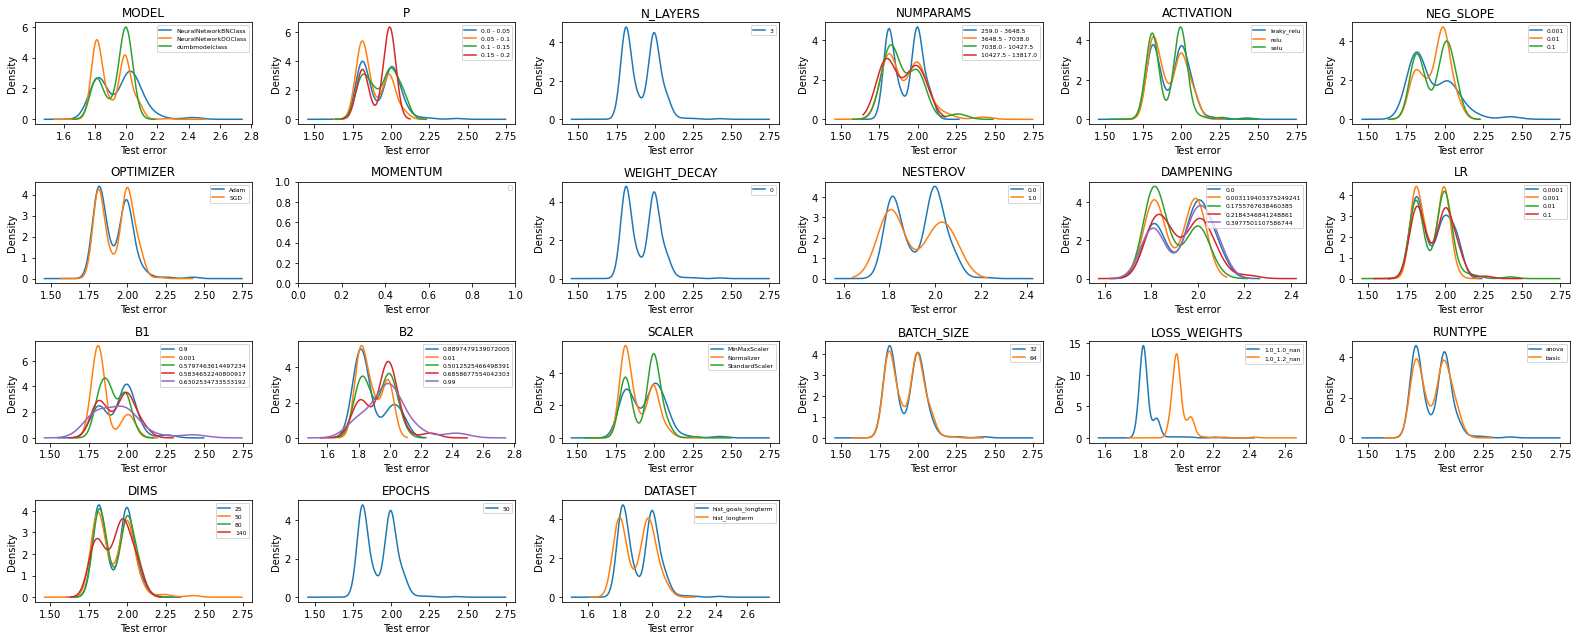

In [81]:
data_plot = results#[flag_mask]
data_plot = data_plot[data_plot.error_test<=2.5]  # hay ~10 outliers con error > 3
fig = plt.figure(figsize=(22,9))
att2plot = 'error_test'

for i,c in enumerate(cols):
    ax = fig.add_subplot(4,6,i+1)
    plots = sorted(data_plot[c].unique())
    nplots = len(plots)
    if nplots > 6: 
        print(c,max(plots))
        q = np.linspace(min(plots),max(plots)+.001,5)
        for j in range(len(q)-1):
            q1 = q[j+1]
            q2 = q[j]
            if q1==q2: print(c,q1,q2)
            data = data_plot[(data_plot[c]<q1) & (data_plot[c]>=q2)]
            if len(data)>1: data[att2plot].plot(kind='kde',label=f'{q2.round(2)} - {q1.round(2)}')
    else: 
        for plot in plots:
            data = data_plot[data_plot[c]==plot]
            if len(data)>1: data[att2plot].dropna().plot(kind='kde',label=plot)
    ax.legend(prop={'size': 6})
    ax.set_title(c.upper())
    ax.set_xlabel('Test error')

plt.tight_layout()
    
plt.savefig(path_summary + f'{exec}_err{balanced}' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

p 0.1949255864554545
numparams 13817


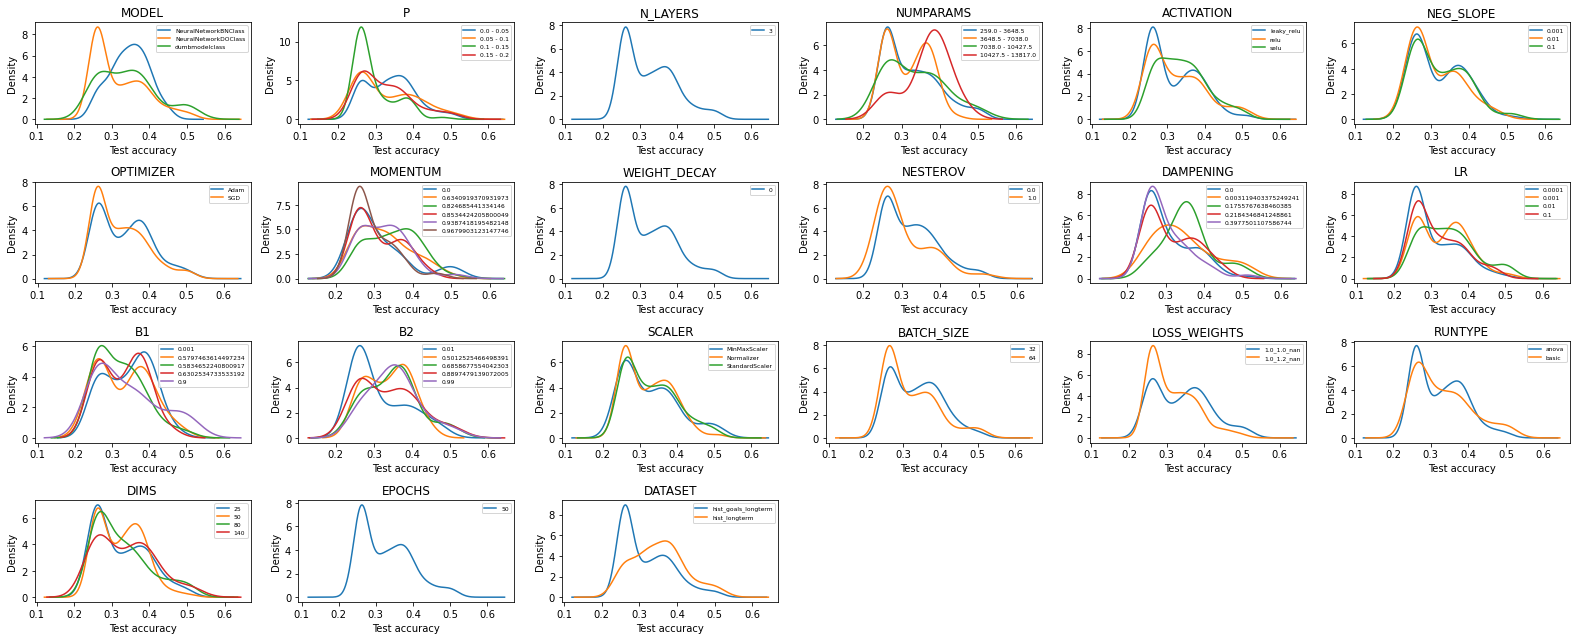

In [82]:
data_plot = results#[flag_mask]
# acc_thr = .46
data_plot = data_plot#[data_plot.acc_test>acc_thr]
fig = plt.figure(figsize=(22,9))
att2plot = 'acc_test'

for i,c in enumerate(cols):
    ax = fig.add_subplot(4,6,i+1)
    plots = sorted(data_plot[c].dropna().unique())
    nplots = len(plots)
    if nplots > 6: 
        print(c,max(plots))
        q = np.linspace(min(plots),max(plots)+.001,5)
        for j in range(len(q)-1):
            q1 = q[j+1]
            q2 = q[j]
            if q1==q2: print(c,q1,q2)
            data = data_plot[(data_plot[c]<q1) & (data_plot[c]>=q2)]
            if len(data)>1: data[att2plot].plot(kind='kde',label=f'{q2.round(2)} - {q1.round(2)}')
    else: 
        for plot in plots:
            data = data_plot[data_plot[c]==plot]
            if len(data)>1: data[att2plot].dropna().plot(kind='kde',label=plot)
    ax.legend(prop={'size': 6})
    ax.set_title(c.upper())
    ax.set_xlabel('Test accuracy')

plt.tight_layout()
    
plt.savefig(path_summary + f'{exec}_acc{balanced}' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

p 0.1873503216501327
numparams 13817


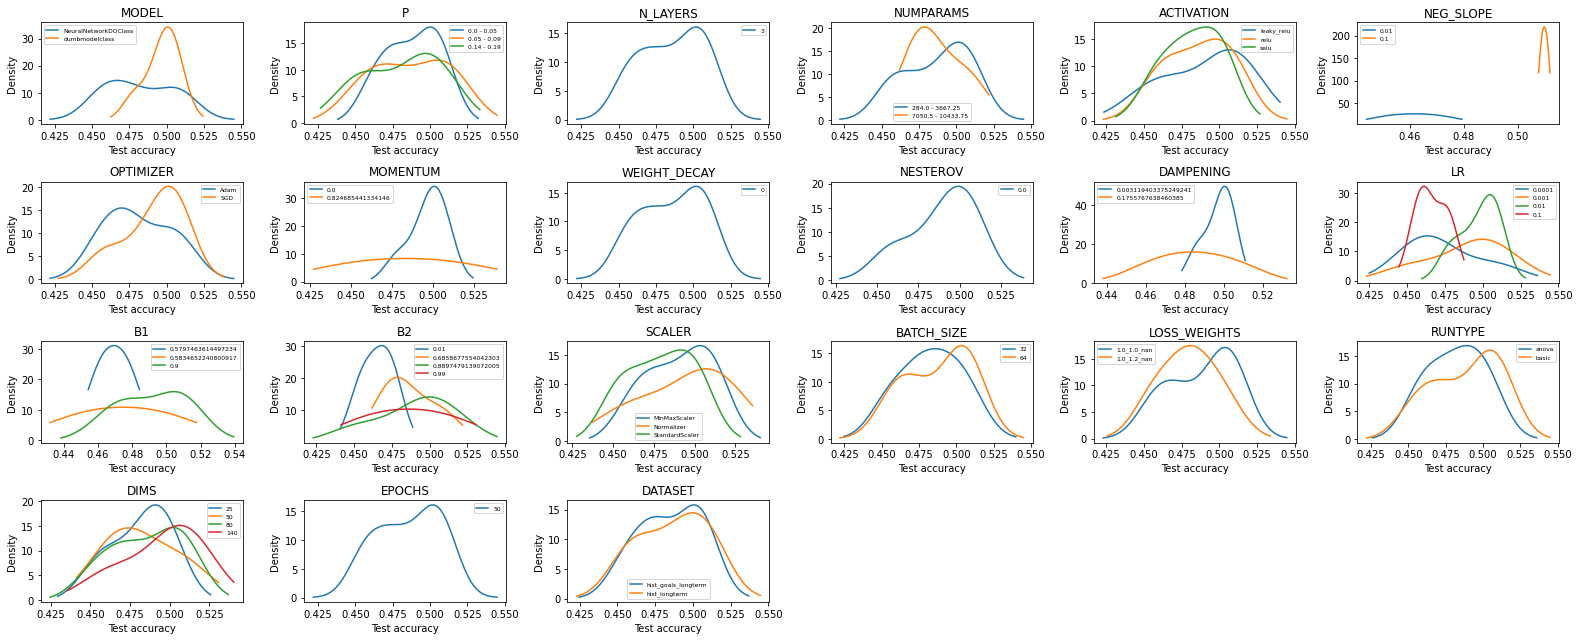

In [84]:
data_plot = results#[flag_mask]
acc_thr = .45
data_plot = data_plot[data_plot.acc_test>acc_thr]
fig = plt.figure(figsize=(22,9))
att2plot = 'acc_test'

for i,c in enumerate(cols):
    ax = fig.add_subplot(4,6,i+1)
    plots = sorted(data_plot[c].dropna().unique())
    nplots = len(plots)
    if nplots > 6: 
        print(c,max(plots))
        q = np.linspace(min(plots),max(plots)+.001,5)
        for j in range(len(q)-1):
            q1 = q[j+1]
            q2 = q[j]
            if q1==q2: print(c,q1,q2)
            data = data_plot[(data_plot[c]<q1) & (data_plot[c]>=q2)]
            if len(data)>1: data[att2plot].plot(kind='kde',label=f'{q2.round(2)} - {q1.round(2)}')
    else: 
        for plot in plots:
            data = data_plot[data_plot[c]==plot]
            if len(data)>1: data[att2plot].dropna().plot(kind='kde',label=plot)
    ax.legend(prop={'size': 6})
    ax.set_title(c.upper())
    ax.set_xlabel('Test accuracy')

plt.tight_layout()
    
plt.savefig(path_summary + f'{exec}_acc{acc_thr}{balanced}' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

p 0.1949255864554545
numparams 13817
momentum 0.9679903123147746


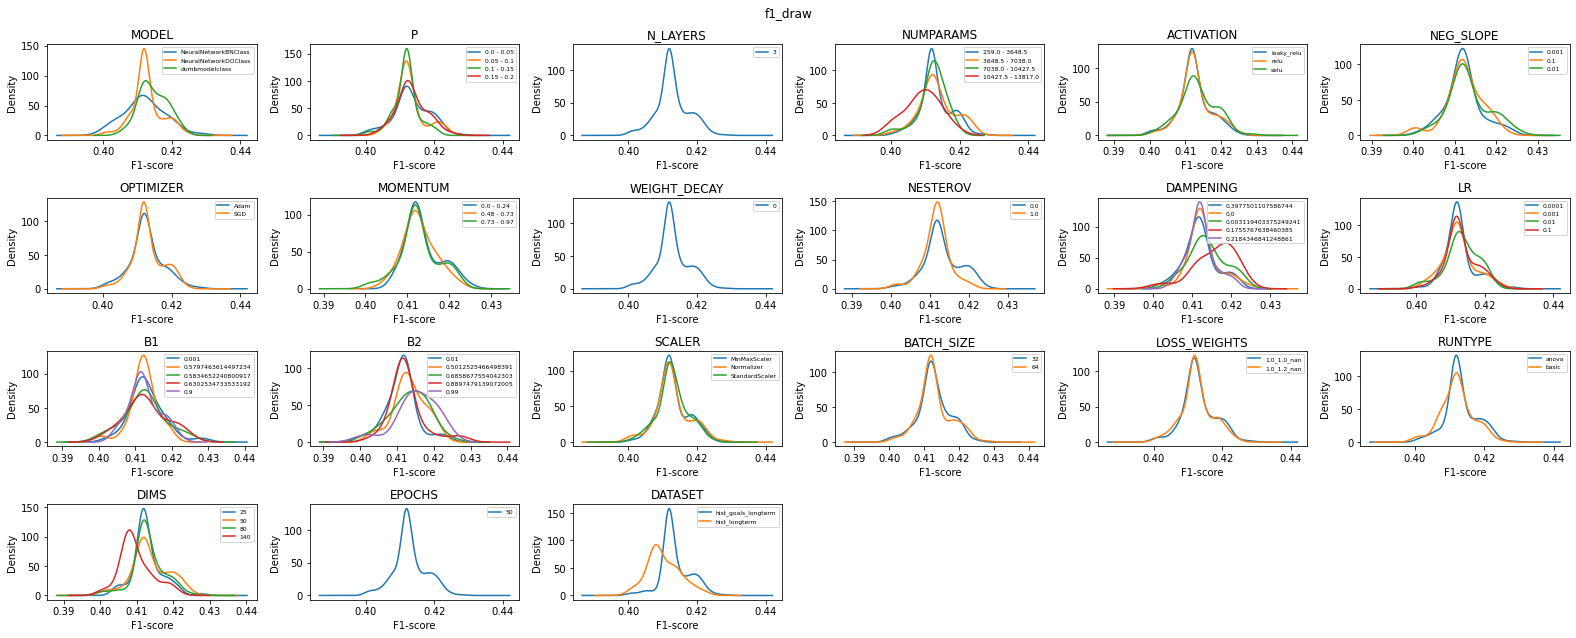

In [87]:
# EXTRA PLOT
data_plot = results#[flag_mask]
data_plot = data_plot[data_plot.f1_draw>.4]  # hay ~10 outliers con error > 3
fig = plt.figure(figsize=(22,9))
att2plot = 'f1_draw'
fig.suptitle(att2plot)
for i,c in enumerate(cols):
    ax = fig.add_subplot(4,6,i+1)
    plots = sorted(data_plot[c].unique())
    nplots = len(plots)
    if nplots > 6: 
        print(c,max(plots))
        q = np.linspace(min(plots),max(plots)+.001,5)
        for j in range(len(q)-1):
            q1 = q[j+1]
            q2 = q[j]
            if q1==q2: print(c,q1,q2)
            data = data_plot[(data_plot[c]<q1) & (data_plot[c]>=q2)]
            if len(data)>1: data[att2plot].plot(kind='kde',label=f'{q2.round(2)} - {q1.round(2)}')
    else: 
        for plot in plots:
            data = data_plot[data_plot[c]==plot]
            if len(data)>1: data[att2plot].dropna().plot(kind='kde',label=plot)
    ax.legend(prop={'size': 6})
    ax.set_title(c.upper())
    ax.set_xlabel('F1-score')

plt.tight_layout()
    
plt.savefig(path_summary + f'{exec}_{att2plot}{balanced}' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')

In [47]:
# plt.figure(figsize=(16,7))
data_plot = results[flag_mask]
plt.scatter(x=data_plot.f1_home,y=data_plot.f1_draw,alpha=.3,s=5)
plt.ylabel('f1 draw'); plt.xlabel('f1 home')

NameError: name 'flag_mask' is not defined

# CHECK RESULTS

In [95]:
def get_embed(y):
    dif = f(y[:,0]) - f(y[:,1])
    res = np.zeros(len(y))
    res[dif==0] = 0
    res[dif>0]  = 1
    res[dif<0]  = 2
    return res

In [96]:
# path_experiments = 'F://TFG//experiments//'
# path_outputs = path_experiments + 'outputs/experiment_hlt_4_117/'
save=False
title = 'rs_reghlfactor10_basic_81'
outputs = pd.read_csv(path_outputs+f'{title}.csv',sep=';',decimal=',').drop('Unnamed: 0',axis=1)
outputs = outputs[(outputs.epoch==max(outputs.epoch)) & (outputs['mode']==1)]

In [97]:
outputs['matchId'] = outputs.matchId.astype(int)
outputs

,matchId,draw_pred,home_pred,away_pred,prediction,label,config.,mode,epoch,HomeTeam,AwayTeam,FTR,FTHG,FTAG
0,155,0.0,0.690239,-0.229929,0.0,0.0,81.0,1.0,49.0,Man United,Tottenham,1,2.0,0.0
1,183,0.0,0.465414,-0.073400,0.0,1.0,81.0,1.0,49.0,Leeds,Aston Villa,2,1.0,2.0
2,191,0.0,-0.078146,0.312730,1.0,1.0,81.0,1.0,49.0,Bradford,Sunderland,2,1.0,4.0
3,195,0.0,-0.222600,0.412908,1.0,0.0,81.0,1.0,49.0,Middlesbrough,Liverpool,1,1.0,0.0
4,196,0.0,0.156239,0.151573,0.0,0.0,81.0,1.0,49.0,Newcastle,Leeds,1,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,2576154,0.0,-0.390378,0.524188,1.0,1.0,81.0,1.0,49.0,Cagliari,Juventus,2,0.0,1.0
3452,2576179,0.0,0.844968,-0.355301,0.0,0.0,81.0,1.0,49.0,Atalanta,Chievo,1,1.0,0.0
3453,2576182,0.0,0.867596,-0.364878,0.0,1.0,81.0,1.0,49.0,Lazio,Genoa,2,1.0,2.0
3454,2576190,0.0,1.037921,-0.481578,0.0,0.0,81.0,1.0,49.0,Roma,Benevento,1,5.0,2.0


In [ ]:
get

In [90]:
path_train      = 'F:\\TFG\\datasets\\raw_datasets\\'
raw_Data  = pd.read_csv(path_train+'historical_longterm'+'.csv',sep=';',decimal=',',index_col='matchId')#.set_index('wyId')

cols = ['HomeTeam',
'AwayTeam',
'FTR',
'FTHG',
'FTAG',
'aux'
]

raw_Data = raw_Data.drop(cols,axis=1,errors='ignore')
raw_Data.sort_index()


,Div,Date,HTHG,HTAG,HTR,HS,AS,HST,AST,HC,...,side_avg_1825D_away,Scored_1825D_away,Received_1825D_away,points_1825D_away,Shots_1825D_away,Target_1825D_away,Corner_1825D_away,Faults_1825D_away,YellowCards_1825D_away,RedCards_1825D_away
matchId,,,,,,,,,,,,,,,,,,,,,
0,E0,2000-08-19,2.0,0.0,H,17.0,8.0,14.0,4.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2000-08-19,1.0,0.0,H,17.0,12.0,10.0,5.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2000-08-19,1.0,1.0,D,6.0,16.0,3.0,9.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2000-08-19,1.0,2.0,A,6.0,13.0,4.0,6.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2000-08-19,2.0,0.0,H,17.0,12.0,8.0,6.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2576334,I1,2018-05-19,0.0,0.0,D,26.0,9.0,13.0,3.0,11.0,...,75.0,174.0,272.0,1.013245,11.364238,3.701987,4.695364,14.218543,2.291391,1.185430
2576335,I1,2018-05-20,2.0,1.0,H,14.0,15.0,4.0,6.0,10.0,...,94.0,306.0,202.0,1.656085,15.158730,4.994709,6.883598,13.476190,2.074074,1.031746
2576336,I1,2018-05-20,0.0,1.0,A,16.0,15.0,3.0,6.0,5.0,...,94.0,358.0,162.0,2.101064,15.941489,5.563830,6.303191,12.643617,1.973404,0.877660


In [91]:
outputs_data = outputs.merge(raw_Data,left_on='matchId',right_index=True,how='left')
outputs_data

,matchId,draw_pred,home_pred,away_pred,prediction,label,config.,mode,epoch,HomeTeam,...,side_avg_1825D_away,Scored_1825D_away,Received_1825D_away,points_1825D_away,Shots_1825D_away,Target_1825D_away,Corner_1825D_away,Faults_1825D_away,YellowCards_1825D_away,RedCards_1825D_away
0,155,0.0,0.690239,-0.229929,0.0,0.0,81.0,1.0,49.0,Man United,...,7.0,22.0,21.0,1.533333,11.200000,5.066667,5.133333,13.933333,1.266667,0.400000
1,183,0.0,0.465414,-0.073400,0.0,1.0,81.0,1.0,49.0,Leeds,...,9.0,21.0,16.0,1.529412,10.058824,4.705882,5.294118,12.470588,1.647059,0.588235
2,191,0.0,-0.078146,0.312730,1.0,1.0,81.0,1.0,49.0,Bradford,...,9.0,19.0,18.0,1.684211,11.263158,5.157895,4.894737,15.631579,1.894737,0.842105
3,195,0.0,-0.222600,0.412908,1.0,0.0,81.0,1.0,49.0,Middlesbrough,...,9.0,37.0,24.0,1.736842,12.526316,6.578947,6.421053,12.789474,1.473684,0.736842
4,196,0.0,0.156239,0.151573,0.0,0.0,81.0,1.0,49.0,Newcastle,...,8.0,25.0,25.0,1.388889,13.055556,5.944444,6.611111,15.666667,1.722222,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3451,2576154,0.0,-0.390378,0.524188,1.0,1.0,81.0,1.0,49.0,Cagliari,...,94.0,382.0,119.0,2.433862,15.957672,5.820106,5.708995,13.380952,1.883598,0.894180
3452,2576179,0.0,0.844968,-0.355301,0.0,0.0,81.0,1.0,49.0,Atalanta,...,95.0,182.0,256.0,1.116402,11.169312,3.486772,4.275132,15.555556,2.343915,1.190476
3453,2576182,0.0,0.867596,-0.364878,0.0,1.0,81.0,1.0,49.0,Lazio,...,95.0,215.0,248.0,1.179894,11.603175,3.973545,5.238095,16.301587,2.433862,1.312169
3454,2576190,0.0,1.037921,-0.481578,0.0,0.0,81.0,1.0,49.0,Roma,...,11.0,13.0,51.0,0.304348,12.478261,3.608696,4.043478,13.043478,1.913043,1.043478


In [92]:
np.bincount(outputs_data.label)/len(outputs_data), np.bincount(outputs_data.prediction)/len(outputs_data)

(array([0.7181713, 0.2818287]), array([0.7103588, 0.2896412]))

In [94]:
outputs_data.prediction.unique()

array([0., 1.])

##### Clustering

In [63]:
col_home, col_away = 'points_1825D_home', 'points_365D_home'
top1825_home = outputs_data.groupby('HomeTeam').agg({col_home:'mean'})
top1825_away = outputs_data.groupby('HomeTeam').agg({col_away:'mean', 'Div':'first'})

# top1825_home.sort_values(col_home), top1825_away.sort_values(col_away)

In [64]:
top1825 = top1825_home.merge(top1825_away,right_index=True,left_index=True)
top1825

,points_1825D_home,points_365D_home,Div
HomeTeam,,,
Aachen,1.200000,1.200000,D1
Ajaccio,0.997462,0.812064,F1
Ajaccio GFCO,1.098767,1.098767,F1
Alaves,1.253913,1.178415,SP1
Almeria,1.157464,1.094766,SP1
...,...,...,...
Wigan,1.177912,1.018885,E0
Wolfsburg,1.436077,1.386902,D1
Wolves,1.231959,1.205733,E0


In [65]:
top1825.columns

Index(['points_1825D_home', 'points_365D_home', 'Div'], dtype='object')

In [66]:
import plotly.express as plotly
top1825 = top1825.reset_index()
plotly.scatter(top1825,col_home,col_away,hover_name='HomeTeam',color='Div',width=1200,height=700)

In [67]:
from sklearn.cluster import KMeans
import random

In [68]:
random.seed(0)
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit(top1825[[col_home,col_away]].pow(4))
order = np.argsort(np.argsort(clusters.cluster_centers_[:,0]))
print(clusters.cluster_centers_[:,0],order,clusters.labels_)
top1825['cluster'] = clusters.labels_
map_ = {c:str(order[c]) for c in top1825.cluster}
print(map_)
top1825['cluster'] = top1825['cluster'].map(map_)
# top1825 = top1825.reset_index()
plotly.scatter(top1825,col_home,col_away,hover_name='HomeTeam',color='cluster',width=1200,height=700)

[21.14366302  1.79228668  8.97859556] [2 0 1] [1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 0 1 1 1 1 2 1 1 1 2 1 1 1 1 2 2 2 1 1
 2 1 1 1 1 2 0 2 1 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 0 1
 1 1 1 2 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1
 2 1 1 1 1 1 1 1 1 1]
{1: '0', 2: '1', 0: '2'}


In [69]:
top1825 = top1825.set_index('HomeTeam').cluster.to_dict()
top1825
# top1825 = top1825.cluster.to_dict()

{'Aachen': '0',
 'Ajaccio': '0',
 'Ajaccio GFCO': '0',
 'Alaves': '0',
 'Almeria': '0',
 'Amiens': '0',
 'Angers': '0',
 'Arles': '0',
 'Arsenal': '1',
 'Ascoli': '0',
 'Aston Villa': '0',
 'Atalanta': '0',
 'Ath Bilbao': '0',
 'Ath Madrid': '1',
 'Augsburg': '0',
 'Auxerre': '0',
 'Barcelona': '2',
 'Bari': '0',
 'Bastia': '0',
 'Bayern Munich': '2',
 'Benevento': '0',
 'Betis': '0',
 'Bielefeld': '0',
 'Birmingham': '0',
 'Blackburn': '0',
 'Blackpool': '0',
 'Bochum': '0',
 'Bologna': '0',
 'Bolton': '0',
 'Bordeaux': '1',
 'Boulogne': '0',
 'Bournemouth': '0',
 'Bradford': '0',
 'Braunschweig': '0',
 'Brescia': '0',
 'Brest': '0',
 'Brighton': '0',
 'Burnley': '0',
 'Cadiz': '0',
 'Caen': '0',
 'Cagliari': '0',
 'Cardiff': '0',
 'Carpi': '0',
 'Catania': '0',
 'Celta': '0',
 'Cesena': '0',
 'Charlton': '0',
 'Chelsea': '2',
 'Chievo': '0',
 'Cordoba': '0',
 'Cottbus': '0',
 'Coventry': '0',
 'Crotone': '0',
 'Crystal Palace': '0',
 'Darmstadt': '0',
 'Derby': '0',
 'Dijon': '0',
 '

In [70]:
outputs_data['cluster_home'] = outputs_data['HomeTeam'].map(top1825).fillna(0).astype(int)
outputs_data['cluster_away'] = outputs_data['AwayTeam'].map(top1825).fillna(0).astype(int)
outputs_data['match_cluster'] = (outputs_data.cluster_home - outputs_data.cluster_away)

In [71]:
outputs_data[['draw_pred','home_pred','away_pred','HomeTeam','AwayTeam','prediction','label','FTR','cluster_home','cluster_away','match_cluster']]

,draw_pred,home_pred,away_pred,HomeTeam,AwayTeam,prediction,label,FTR,cluster_home,cluster_away,match_cluster
0,-0.074028,0.293268,-0.701021,Man United,Tottenham,1.0,1.0,1,2,1,1
1,-0.072796,0.148573,-0.563363,Leeds,Aston Villa,1.0,2.0,2,1,0,1
2,-0.070238,-0.300377,-0.082778,Bradford,Sunderland,0.0,2.0,2,0,0,0
3,-0.084789,-0.500925,0.197080,Middlesbrough,Liverpool,2.0,1.0,1,0,1,-1
4,-0.066218,-0.063674,-0.336764,Newcastle,Leeds,1.0,1.0,1,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...
3451,-0.136636,-0.818385,0.641445,Cagliari,Juventus,2.0,2.0,2,0,2,-2
3452,-0.070645,0.420296,-0.829002,Atalanta,Chievo,1.0,1.0,1,0,0,0
3453,-0.099158,0.532391,-0.944721,Lazio,Genoa,1.0,2.0,2,1,0,1
3454,-0.079200,0.628673,-1.015550,Roma,Benevento,1.0,1.0,1,1,0,1


In [72]:
outputs_data['isaccurate'] = outputs_data.prediction==outputs_data.label

In [73]:
#  QUE PASA EN LA REALIDAD - Como se distribuyen los resultados a lo largo de los clusters
outputs_data.groupby(['match_cluster','label']).isaccurate.count().to_frame()

isaccurate
match_cluster label            
-2            0.0            40
              1.0            27
              2.0           112
-1            0.0           179
              1.0           195
              2.0           283
 0            0.0           511
              1.0           810
              2.0           485
 1            0.0           134
              1.0           424
              2.0            77
 2            0.0            22
              1.0           140
              2.0            17

##### Type of match accuracy

In [74]:
# ACCURACY (per type of match)
outputs_data.groupby(['match_cluster']).agg({'isaccurate':['mean','count']}) #    .isaccurate.mean().to_frame()

isaccurate      
                    mean count
match_cluster                 
-2              0.608939   179
-1              0.432268   657
 0              0.433555  1806
 1              0.661417   635
 2              0.782123   179

In [75]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

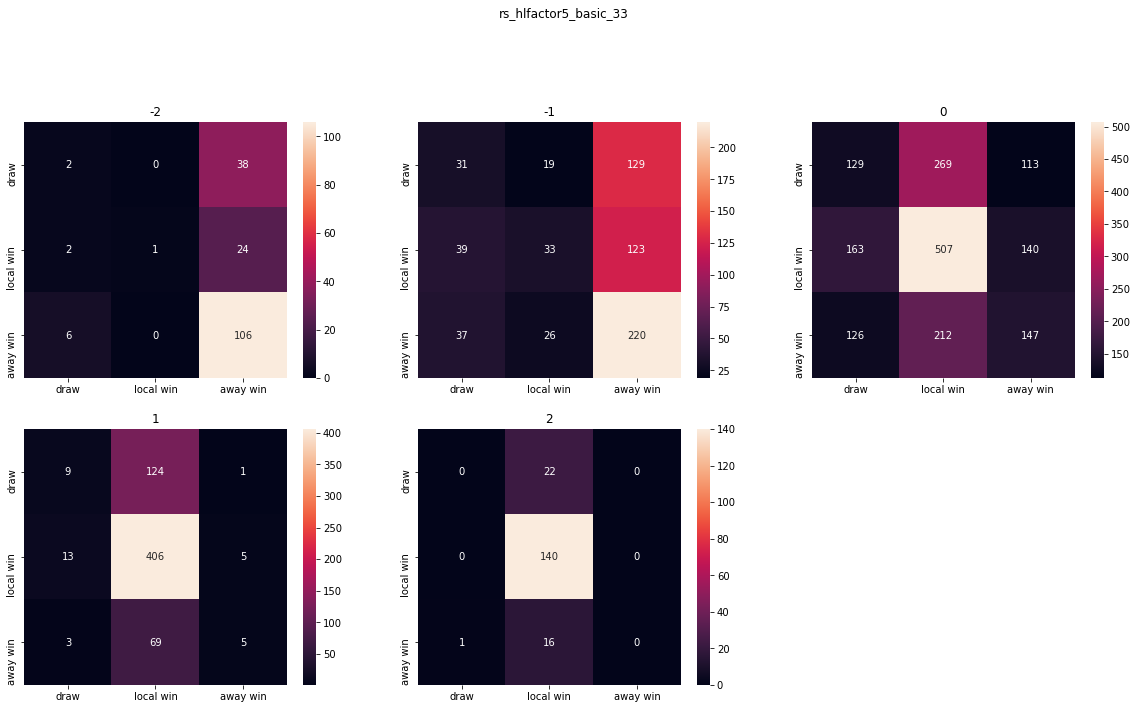

In [76]:
f = plt.figure(0)
f.set_size_inches(20,16)
f.suptitle(title)
for i,m in enumerate([-2,-1,0,1,2]):
    ax = f.add_subplot(3,3,i+1)
    conf_data = outputs_data[outputs_data.match_cluster==m]
    df_confmat = confusion_matrix(conf_data.label,conf_data.prediction,labels=[0,1,2])
    df_confmat = pd.DataFrame(df_confmat, index=['draw','local win','away win'], columns=['draw','local win','away win'])
    sn.heatmap(df_confmat,annot=True,fmt=".0f")
    ax.set_title(m)

##### Competition accuracy


In [77]:
acc_div = outputs_data.groupby(['Div']).agg({'isaccurate':['mean','count']}) #    .isaccurate.mean().to_frame()
acc_div

isaccurate      
          mean count
Div                 
D1    0.507513   599
E0    0.541272   739
F1    0.465870   586
I1    0.489569   719
SP1   0.500615   813

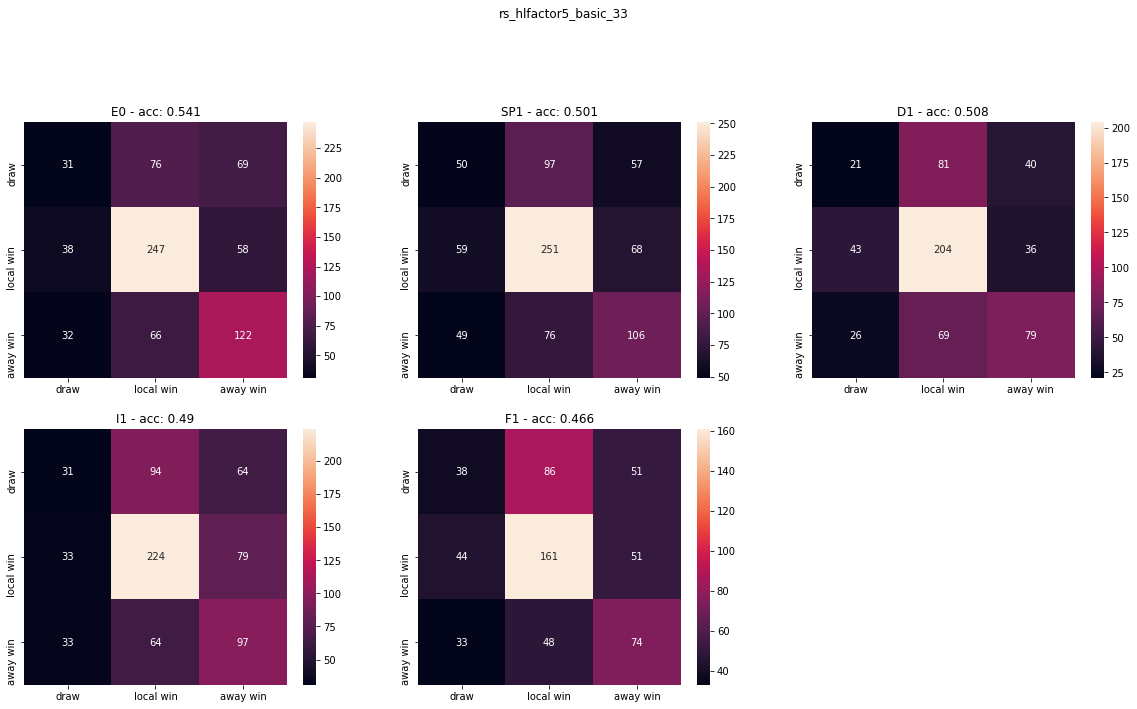

In [78]:
f = plt.figure(0)
f.set_size_inches(20,16)
f.suptitle(title)

for i,m in enumerate(outputs_data.Div.unique()):
    ax = f.add_subplot(3,3,i+1)
    conf_data = outputs_data[outputs_data.Div==m]
    df_confmat = confusion_matrix(conf_data.label,conf_data.prediction,labels=[0,1,2])
    df_confmat = pd.DataFrame(df_confmat, index=['draw','local win','away win'], columns=['draw','local win','away win'])
    sn.heatmap(df_confmat,annot=True,fmt=".0f")
    ax.set_title(f'{m} - acc: {round(acc_div["isaccurate"]["mean"].loc[m],3)}')
if save: f.savefig(path_summary + f'{title}_divs' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')


##### Season accuracy

In [79]:
kk = pd.DataFrame(ml.FootballMatchesDataset('test','historical_longterm').matches)
kk

,0
0,155
1,183
2,191
3,195
4,196
...,...
3467,2576327
3468,2576331
3469,2576333
3470,2576336


In [80]:
kk.merge(raw_Data,left_on=0,right_index=True,how='left').season.to_frame().value_counts()

# tras cambiar el permutation del FootballMatchesDataset, la temporada 2017-18 ya aparece en el test !

season
1314      245
1011      231
1516      230
1112      229
910       228
2021      225
1415      222
809       221
708       217
1213      209
607       202
1617      198
1819      195
1718      185
1920      175
203        76
506        72
102        42
1          37
405        33
dtype: int64

In [81]:
acc_season = outputs_data.groupby(['season']).agg({'isaccurate':['mean','count']}) #    .isaccurate.mean().to_frame()
acc_season

isaccurate      
             mean count
season                 
1        0.405405    37
102      0.380952    42
203      0.500000    76
405      0.484848    33
506      0.541667    72
607      0.500000   202
708      0.442396   217
809      0.502262   221
910      0.526316   228
1011     0.454545   231
1112     0.554585   229
1213     0.497608   209
1314     0.555102   245
1415     0.481982   222
1516     0.469565   230
1617     0.525253   198
1718     0.520710   169
1819     0.517949   195
1920     0.474286   175
2021     0.537778   225

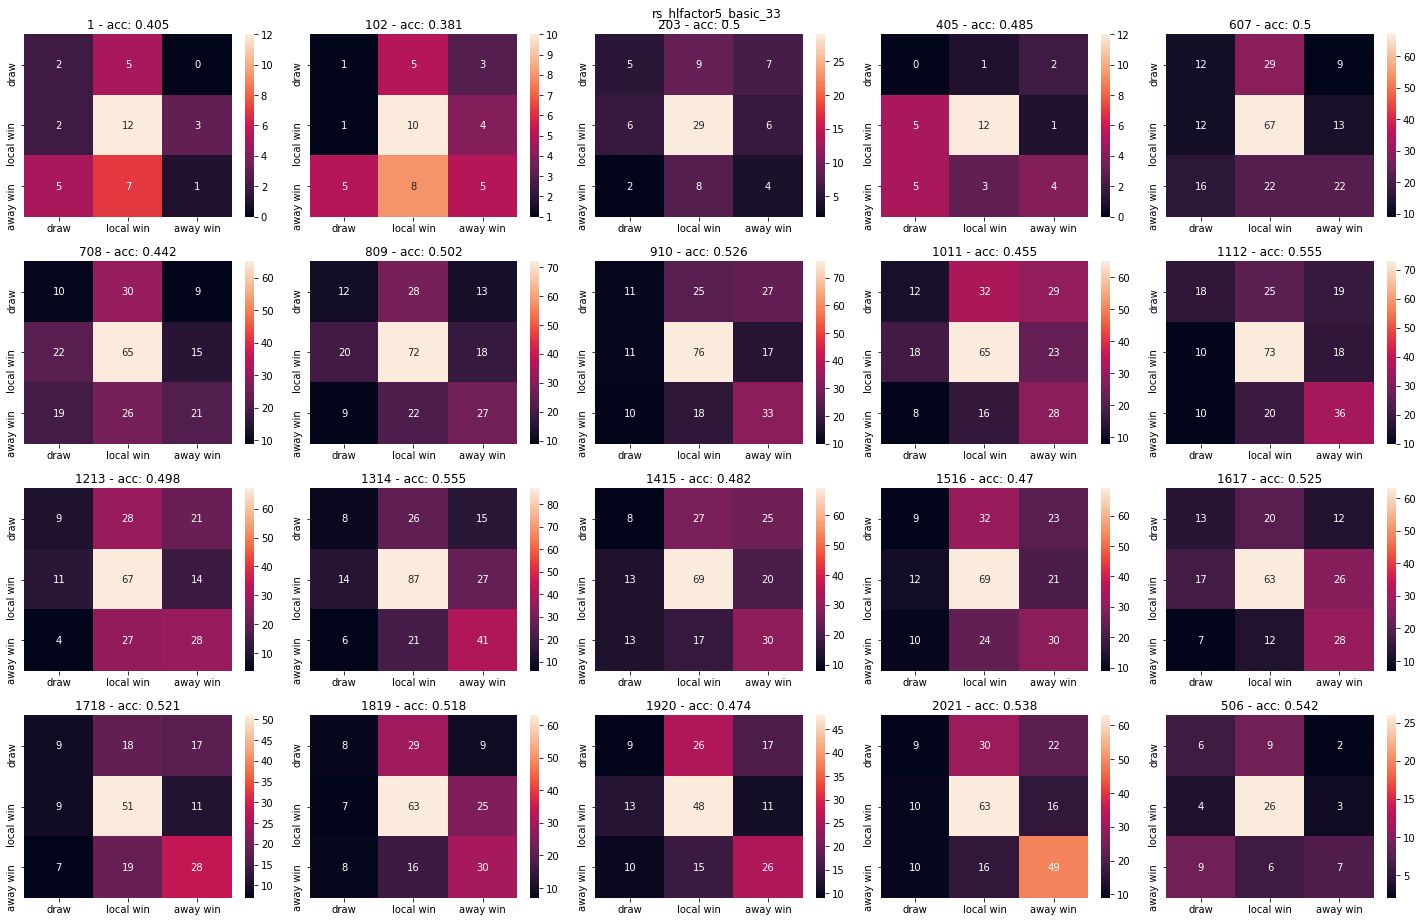

In [82]:
f = plt.figure(0)
f.set_size_inches(20,16)
f.suptitle(title)

for i,m in enumerate(outputs_data.season.unique()):
    ax = f.add_subplot(5,5,i+1)
    conf_data = outputs_data[outputs_data.season==m]
    df_confmat = confusion_matrix(conf_data.label,conf_data.prediction,labels=[0,1,2])
    df_confmat = pd.DataFrame(df_confmat, index=['draw','local win','away win'], columns=['draw','local win','away win'])
    sn.heatmap(df_confmat,annot=True,fmt=".0f")
    ax.set_title(f'{m} - acc: {round(acc_season["isaccurate"]["mean"].loc[m],3)}')
f.tight_layout()
if save: f.savefig(path_summary + f'{title}_season' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')


##### Month accuracy

In [83]:
outputs_data['month'] = outputs_data.Date.apply(lambda x: int(x.split('-')[1]))

In [84]:
acc_month = outputs_data.groupby(['month']).agg({'isaccurate':['mean','count']}) #    .isaccurate.mean().to_frame()
acc_month

isaccurate      
            mean count
month                 
1       0.529825   285
2       0.471374   524
3       0.489270   466
4       0.538622   479
5       0.484513   452
6       0.500000    16
7       0.571429    35
8       0.430556    72
9       0.572254   173
10      0.463087   149
11      0.483395   271
12      0.514981   534

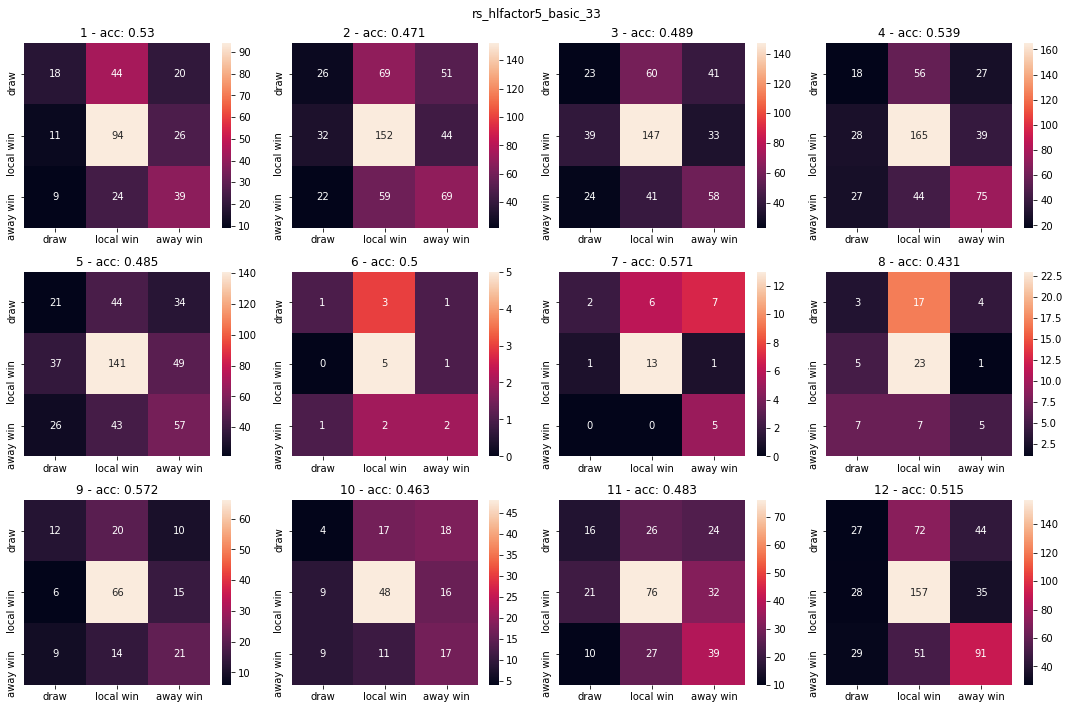

In [85]:
f = plt.figure(0)
f.set_size_inches(15,10)
f.suptitle(title)
for i,m in enumerate(sorted(outputs_data.month.unique())):
    ax = f.add_subplot(3,4,i+1)
    conf_data = outputs_data[outputs_data.month==m]
    df_confmat = confusion_matrix(conf_data.label,conf_data.prediction,labels=[0,1,2])
    df_confmat = pd.DataFrame(df_confmat, index=['draw','local win','away win'], columns=['draw','local win','away win'])
    sn.heatmap(df_confmat,annot=True,fmt=".0f")
    ax.set_title(f'{m} - acc: {round(acc_month["isaccurate"]["mean"].loc[m],3)}')
f.tight_layout()

##### CLUSTERING accuracy

In [86]:
acc_cluster = outputs_data.groupby(['cluster_home','cluster_away']).agg({'isaccurate':['mean','count']}) #    .isaccurate.mean().to_frame()
acc_cluster

isaccurate      
                                mean count
cluster_home cluster_away                 
0            0              0.430318  1636
             1              0.432520   615
             2              0.608939   179
1            0              0.659829   585
             1              0.475610   164
             2              0.428571    42
2            0              0.782123   179
             1              0.680000    50
             2              0.166667     6

[[2 2]
 [1 2]
 [0 2]
 [2 1]
 [1 1]
 [0 1]
 [2 0]
 [1 0]
 [0 0]]


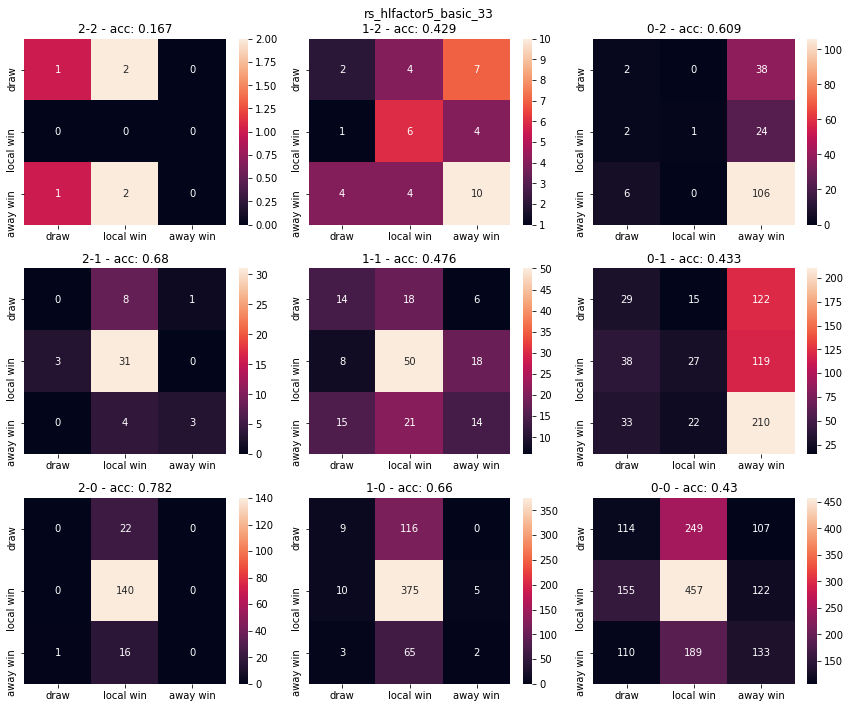

In [90]:
f = plt.figure(0)
f.set_size_inches(12,13)
f.suptitle(title)
vals = np.array(np.meshgrid(outputs_data.cluster_home.unique(),outputs_data.cluster_home.unique())).reshape(2,len(outputs_data.cluster_home.unique())**2).T
# vals = np.sort(vals)
print(vals)
for i,(h,a) in enumerate(vals):
    ax = f.add_subplot(4,3,i+1)
    conf_data = outputs_data[(outputs_data.cluster_home==h) & (outputs_data.cluster_away==a)]
    df_confmat = confusion_matrix(conf_data.label,conf_data.prediction,labels=[0,1,2])
    df_confmat = pd.DataFrame(df_confmat, index=['draw','local win','away win'], columns=['draw','local win','away win'])
    sn.heatmap(df_confmat,annot=True,fmt=".0f")
    ax.set_title(f'{h}-{a} - acc: {round(acc_cluster["isaccurate"]["mean"].loc[h,a],3)}')
f.tight_layout()
if save: f.savefig(path_summary + f'{title}_3clusters' + '.jpg', format='jpg', dpi=200, bbox_inches='tight')


#### CLUSTER EQUIPO-TEMPORADA

In [60]:
outputs_data

,matchId,draw_pred,home_pred,away_pred,prediction,label,config.,mode,epoch,HomeTeam,...,Target_1825D_away,Corner_1825D_away,Faults_1825D_away,YellowCards_1825D_away,RedCards_1825D_away,cluster_home,cluster_away,match_cluster,isaccurate,month
16960,559,0.317113,0.233864,0.449023,2.0,2.0,92.0,1.0,199.0,Aston Villa,...,6.090909,5.781818,12.527273,1.345455,0.600000,1,3,-2,True,12
16961,564,0.295648,0.571759,0.132593,1.0,1.0,92.0,1.0,199.0,Ipswich,...,4.160714,4.535714,12.678571,1.678571,0.767857,0,1,-1,True,12
16962,586,0.277735,0.555044,0.167221,1.0,1.0,92.0,1.0,199.0,Man United,...,5.224138,5.775862,14.534483,1.413793,0.568966,3,1,2,True,1
16963,609,0.297899,0.153020,0.549081,2.0,2.0,92.0,1.0,199.0,Leicester,...,7.616667,7.366667,14.033333,1.733333,0.783333,1,3,-2,True,1
16964,636,0.291018,0.547918,0.161064,1.0,1.0,92.0,1.0,199.0,Newcastle,...,4.587302,5.142857,14.142857,1.158730,0.555556,1,1,0,True,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18651,48290,0.318928,0.556727,0.124344,1.0,1.0,92.0,1.0,199.0,Rennes,...,3.708571,4.245714,13.525714,1.902857,1.011429,2,0,2,True,4
18652,48296,0.329619,0.499323,0.171057,1.0,1.0,92.0,1.0,199.0,Lille,...,4.235955,4.365169,11.398876,1.921348,0.921348,2,1,1,True,5
18653,48298,0.386481,0.357246,0.256273,0.0,2.0,92.0,1.0,199.0,Brest,...,3.724719,4.831461,13.320225,1.904494,0.943820,0,1,-1,False,5
18654,48299,0.358910,0.309244,0.331846,0.0,2.0,92.0,1.0,199.0,Dijon,...,3.652174,4.224638,13.275362,1.971014,0.971014,0,0,0,False,5


In [121]:
raw_Data  = pd.read_csv(path_train+'historical_longterm'+'.csv',sep=';',index_col='matchId')#.set_index('wyId')
pd.options.display.max_rows = 200
raw_Data.groupby(['Div','season']).agg({'HomeTeam':['count']})

HomeTeam
              count
Div season         
D1  1           306
    203         306
    607         306
    708         306
    809         306
    910         306
    1011        306
    1112        306
    1213        306
    1314        306
    1415        306
    1516        306
    1617        306
    1718        306
    1819        306
    1920        306
    2021        288
E0  1           380
    102         380
    203         380
    405         380
    607         380
    708         380
    809         380
    910         380
    1011        380
    1112        380
    1213        380
    1314        380
    1415        380
    1516        380
    1617        380
    1718        380
    1819        380
    1920        380
    2021        350
F1  708         380
    809         380
    910         380
    1011        380
    1112        378
    1213        380
    1314        380
    1415        380
    1516        380
    1617        379
    1718        380
    1819        380
    1920        279
    2021        380
I1  506         366
    607         380
    708         380
    809         380
    910         380
    1011        380
    1112        380
    1213        379
    1314        380
    1415        379
    1516        380
    1617        379
    1718        380
    1819        380
    1920        380
    2021        358
SP1 506         380
    607         380
    708         380
    809         380
    910         380
    1011        380
    1112        380
    1213        380
    1314        380
    1415        380
    1516        380
    1617        380
    1718        380
    1819        380
    1920        380
    2021        380

In [148]:
raw_Data  = pd.read_csv(path_train+'historical_longterm'+'.csv',sep=';',index_col='matchId')#.set_index('wyId')

col_home, col_away = 'points_1825D_home', 'points_730D_home'
# col_home, col_away = 'points_365D_home', 'points_365D_away'

top1825_home = raw_Data.groupby(['HomeTeam','season']).agg({col_home:'mean'})
top1825_away = raw_Data.groupby(['HomeTeam','season']).agg({col_away:'mean', 'Div':'first'})
top1825_away

points_730D_home  Div
HomeTeam     season                       
Aachen       708                  NaN   D1
Ajaccio      1112                 NaN   F1
             1213            1.112056   F1
             1314            1.014931   F1
Ajaccio GFCO 1516                 NaN   F1
...                               ...  ...
Zaragoza     708             1.373405  SP1
             910                  NaN  SP1
             1011            1.026046  SP1
             1112            1.087069  SP1
             1213            1.162387  SP1

[1606 rows x 2 columns]

In [149]:
top1825 = pd.merge(
    left=top1825_home.reset_index(), right=top1825_away.reset_index(),
    left_on=['season','HomeTeam'], right_on=['season','HomeTeam'],
    how='inner'
)
top1825

,HomeTeam,season,points_1825D_home,points_730D_home,Div
0,Aachen,708,NaN,NaN,D1
1,Ajaccio,1112,NaN,NaN,F1
2,Ajaccio,1213,1.112056,1.112056,F1
3,Ajaccio,1314,0.999109,1.014931,F1
4,Ajaccio GFCO,1516,NaN,NaN,F1
...,...,...,...,...,...
1601,Zaragoza,708,1.356581,1.373405,SP1
1602,Zaragoza,910,1.255794,NaN,SP1
1603,Zaragoza,1011,1.202819,1.026046,SP1
1604,Zaragoza,1112,1.128988,1.087069,SP1


In [150]:
raw_Data[raw_Data.HomeTeam=='Barcelona'][raw_Data.season==1314][['Date','HomeTeam','AwayTeam','points_365D_home']]

<ipython-input-150-e37cc4e176c1>:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,Date,HomeTeam,AwayTeam,points_365D_home
matchId,,,,
15274,2013-08-18,Barcelona,Levante,2.631579
15302,2013-09-14,Barcelona,Sevilla,2.631579
15322,2013-09-24,Barcelona,Sociedad,2.631579
15343,2013-10-05,Barcelona,Valladolid,2.641026
15362,2013-10-26,Barcelona,Real Madrid,2.641026
15381,2013-11-01,Barcelona,Espanol,2.650000
15404,2013-11-23,Barcelona,Granada,2.641026
15422,2013-12-14,Barcelona,Villarreal,2.552632
15445,2014-01-05,Barcelona,Elche,2.552632


In [151]:
plotly.scatter(top1825,col_home,col_away,hover_name='HomeTeam',hover_data=['season'],color='Div',width=1200,height=700)
# plotly.line(np.arange)